# Imports

## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import random
import importlib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, LeavePGroupsOut, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pylab import *
import seaborn as sns
import tensorflow as tf
from scipy import stats
from mlxtend.evaluate import paired_ttest_5x2cv

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.facecolor']='white'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Helpers

In [2]:
import sys
sys.path.append("../")

# Custom Cross Validation for samecity
import Helpers.Each_city_10fold_CV
importlib.reload(Helpers.Each_city_10fold_CV)
from Helpers.Each_city_10fold_CV import CustomCrossValidation

# glove preprocessings
import Helpers.Glove_transform
importlib.reload(Helpers.Glove_transform)
from Helpers.Glove_transform import GloveTransform

# Stanford tokenizer
import Helpers.Stanford_Tokenizer
importlib.reload(Helpers.Stanford_Tokenizer)
from Helpers.Stanford_Tokenizer import StanfordTokenizer

# Tweet tokenizer(from C-BiGRU paper)
import Helpers.Tweet_Tokenizer
importlib.reload(Helpers.Tweet_Tokenizer)
from Helpers.Tweet_Tokenizer import TweetTokenize

# glove embeddings
import Helpers.Glove_twitter_embeddings
importlib.reload(Helpers.Glove_twitter_embeddings)
from Helpers.Glove_twitter_embeddings import GloveTwitterEmbeddings

# glove common crawl
import Helpers.Glove_CommonCrawl_embeddings
importlib.reload(Helpers.Glove_CommonCrawl_embeddings)
from Helpers.Glove_CommonCrawl_embeddings import GloveCommomCrawlEmbeddings

# Word embedding(from C-BiGRU paper)
import Helpers.Word2Vec_Twitter
importlib.reload(Helpers.Word2Vec_Twitter)
from Helpers.Word2Vec_Twitter import Word2VecTwitter

# Fasttext embedding
import Helpers.Fasttext_Twitter
importlib.reload(Helpers.Fasttext_Twitter)
from Helpers.Fasttext_Twitter import FasttextTwitter

# Padding
import Helpers.Padding
importlib.reload(Helpers.Padding)
from Helpers.Padding import Padding

# Kears sklearn CNN classifier
import Helpers.CNN_SciKeras_Classifier
importlib.reload(Helpers.CNN_SciKeras_Classifier)
from Helpers.CNN_SciKeras_Classifier import CNN_classifier

# Kears sklearn CBiGRU classifier
import Helpers.CBiGRU_SciKeras_Classifier
importlib.reload(Helpers.CBiGRU_SciKeras_Classifier)
from Helpers.CBiGRU_SciKeras_Classifier import CBiGRU_classifier

/root/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Directory to store results

In [3]:
results_dir = Path('../../results/idsc_binary')
results_dir.mkdir(parents=True, exist_ok=True)

results_plot = Path('../../results/plots')
results_plot.mkdir(parents=True, exist_ok=True)

# Dataset

In [3]:
TwoCVTweets = "../../Datasets/Incident-Related-Twitters/2CVTweets/"

data = pd.DataFrame(columns=["text", "label", "groups"])

for i, data_file in enumerate(os.listdir(TwoCVTweets)):
    data_sample = pd.read_csv(TwoCVTweets + data_file, delimiter=";", names=["text", "label"], encoding="ISO-8859-1")
    data_sample["groups"] = i
    data_sample.label = data_sample.label.map(dict(YES=1, NO=0))
    data = pd.concat([data, data_sample])

# data.label = data.label.astype("int")

x_train, y_train = data.text, data.label
groups = data.groups

In [4]:
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)

## Class weights

In [5]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train      
                                    )

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.645151903154464, 1: 2.2223336006415395}

# Experiments

## SVM + TF-IDF

### Pipeline

In [7]:
# Define component objects of our pipeline then create it!
objs = [("tfidf", TfidfVectorizer()),
        ("svm", SVC(kernel="linear"))]
pipe = Pipeline(objs)
pipe.named_steps

{'tfidf': TfidfVectorizer(), 'svm': SVC(kernel='linear')}

### Cross validation

In [8]:
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
pipe.set_params(svm__C=1.0)
pipe.set_params(tfidf__ngram_range=(1, 2))
cv_results = cross_validate(pipe, 
                                x_train, y_train,
                                groups=groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring=["average_precision", "f1_macro"])

In [9]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_f1_macro"]), np.std(cv_results["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_average_precision"]), np.std(cv_results["test_average_precision"])))

F1_Macro: Mean-0.897, std-0.026
Average Precision: Mean-0.913, std-0.032


In [10]:
results = pd.DataFrame(cv_results)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"), index=False)

## CNN + Glove Twitter Word Embeddings

### Pipeline

In [11]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f31c85c80d0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f31c85e25e0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [12]:
pipe_CNN.set_params(net__verbose=0)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)

cv_results_CNN = cross_validate(pipe_CNN, 
                                x_train, y_train,
                                groups = groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring=["average_precision", "f1_macro"])

In [13]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.895, std-0.025
Average Precision: Mean-0.914, std-0.033


In [14]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"), index=False)

### Hypothesis Test for Comparing SVM+TF-IDF and CNN+Glove

In [6]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))

ttest = stats.ttest_ind(SVM_results["Average Precision"], CNN_results["Average Precision"])

print("P Value:", ttest.pvalue)

# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

P Value: 0.7672324333100012
Algorithms probably have the same performance


## CNN + Glove Common Crawl Word Embeddings

### Pipeline

In [15]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f31c85c80d0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f31c85e25e0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [16]:
pipe_CNN.set_params(net__verbose=0)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)

cv_results_CNN = cross_validate(pipe_CNN, 
                                x_train, y_train,
                                groups = groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring=["average_precision", "f1_macro"])

In [17]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.897, std-0.027
Average Precision: Mean-0.915, std-0.032


In [18]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CNN.csv"), index=False)

## CNN + Word2Vec Twitter Embeddings

### Pipeline

In [19]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f31c85c80d0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f31c85e25e0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [20]:
pipe_CNN.set_params(net__verbose=0)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)

cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            groups = groups,
                            cv=cv,
                            n_jobs=-1,
                            scoring=["average_precision", "f1_macro"])

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

In [ ]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CNN.csv"), index=False)

## CNN + FastText Twitter Embeddings

### Pipeline

In [13]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("Fasttext", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'Fasttext': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7fe26f7c2310>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7fe26f7de8b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [14]:
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            groups = groups,
                            cv=cv,
                            n_jobs=2,
                            scoring=["average_precision", "f1_macro"])

In [15]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_f1_macro"]), np.std(cv_results_CNN["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_average_precision"]), np.std(cv_results_CNN["test_average_precision"])))

F1_Macro: Mean-0.900, std-0.028
Average Precision: Mean-0.919, std-0.033


In [16]:
results = pd.DataFrame(cv_results_CNN)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CNN.csv"), index=False)

## C-BiGRU + Glove Twitter Word Embeddings

### Pipeline

In [17]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fe26f7e3dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe26f7debe0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [18]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring=["average_precision", "f1_macro"])

In [19]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.867, std-0.034
Average Precision: Mean-0.884, std-0.045


In [20]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"), index=False)

### Hypothesis Test for Comparing CNN+Glove and C-BiGRU+Glove

In [7]:
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))
CBiGRU_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"))

ttest = stats.ttest_ind(CBiGRU_results["Average Precision"], CNN_results["Average Precision"])

# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

Difference between mean performance is probably real


## C-BiGRU + Glove Common Crawl Word Embeddings

### Pipeline

In [21]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fe26f7e3dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe26f7debe0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [22]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring=["average_precision", "f1_macro"])

In [23]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.871, std-0.036
Average Precision: Mean-0.888, std-0.043


In [24]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CBiGRU.csv"), index=False)

## C-BiGRU + Word2Vec Twitter Embeddings

### Pipeline

In [25]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fe26f7e3dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe26f7debe0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [27]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = 3,
                                   scoring=["average_precision", "f1_macro"])

In [28]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.873, std-0.032
Average Precision: Mean-0.898, std-0.039


In [29]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CBiGRU.csv"), index=False)

## C-BiGRU + FastText Twitter Embeddings

### Pipeline

In [30]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fe26f7e3dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe26f7debe0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [31]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = CustomCrossValidation.split(X=x_train, y=y_train, groups=groups)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   scoring=["average_precision", "f1_macro"])

In [32]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_f1_macro"]), np.std(cv_results_CBiGRU["test_f1_macro"])))
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_average_precision"]), np.std(cv_results_CBiGRU["test_average_precision"])))

F1_Macro: Mean-0.865, std-0.035
Average Precision: Mean-0.894, std-0.040


In [33]:
results = pd.DataFrame(cv_results_CBiGRU)[["test_average_precision", "test_f1_macro"]]
results.rename(columns={"test_average_precision": "Average Precision", "test_f1_macro": "F1 Macro"}, inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CBiGRU.csv"), index=False)

# Hypothesis Test

## Average Precision

In [6]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))

        ttest = stats.ttest_ind(SVM_results["Average Precision"], other_results["Average Precision"])
        print("P Value:", ttest.pvalue)

        # interpret the result
        if ttest.pvalue <= 0.05:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Twitter_Embeddings_CBiGRU
P Value: 3.4974613403653255e-07
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CNN
P Value: 0.6183738858907653
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CBiGRU
P Value: 0.000402518399170307
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CNN
P Value: 0.16054898922298722
Algorithms probably have the same performance
------------------------------------------------------
Word2Vec_Twitter_CBiGRU
P Value: 0.005944692146167918
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
P Value: 7.602165197370386e-06
Difference between mean performance is probably real
------------------------------------------------------
Glove_Twitter_

## F1 Macro

In [7]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))

        ttest = stats.ttest_ind(SVM_results["F1 Macro"], other_results["F1 Macro"])
        print("P Value:", ttest.pvalue)

        # interpret the result
        if ttest.pvalue <= 0.05:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Twitter_Embeddings_CBiGRU
P Value: 3.847115731034427e-11
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CNN
P Value: 0.8646586629978569
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CBiGRU
P Value: 5.116615514246095e-12
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CNN
P Value: 0.8888902929926505
Algorithms probably have the same performance
------------------------------------------------------
Word2Vec_Twitter_CBiGRU
P Value: 2.5512022408147816e-08
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
P Value: 1.2257158521979356e-08
Difference between mean performance is probably real
------------------------------------------------------
Glove_Twitte

# Plots

In [4]:
data = pd.DataFrame(columns=["x_axis","Average Precision", "F1 Macro", "Experiments", "Model"])
for i, file in enumerate(os.listdir(results_dir)):
        data_sample = pd.read_csv(Path.joinpath(results_dir, file))
        if "CNN" in file:
            data_sample["Model"] = "CNN"
            file = file.replace("CNN", "")
        elif "CBiGRU" in file:
            data_sample["Model"] = "C-BiGRU"
            file = file.replace("CBiGRU", "")
        else: data_sample["Model"] = "SVM"
        data_sample["Experiments"] = file.replace("_", "\n").replace(".csv","")
        data_sample["x_axis"]=i
        data = pd.concat([data, data_sample[["x_axis","Average Precision", "F1 Macro", "Experiments", "Model"]]])
        
data = data.astype({"Experiments":"category", "Model":"category", "x_axis": "category", "F1 Macro":"float64", "Average Precision":"float64"})

In [5]:
grp = data.groupby(['Model', 'Experiments'])['Average Precision'].mean().sort_values().iloc[::-1]
grp_index = grp[~grp.isna()].index 
seen = set()
seen_add = seen.add
order = [x[1] for x in grp_index if not (x[1] in seen or seen_add(x[1]))][::-1]

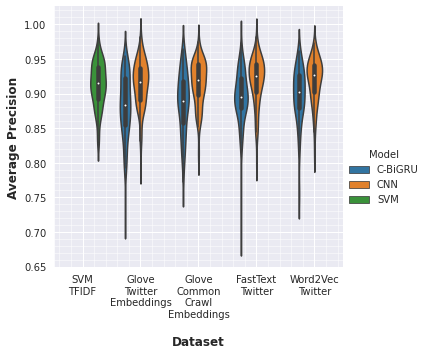

In [6]:
sns.set_style("darkgrid")
 
g = sns.catplot(x="Experiments", y="Average Precision",
               data=data, kind="violin", hue="Model", order=order)

for ax in g.axes.flat:
    ax.get_xaxis().set_minor_locator(AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', color='w', linewidth=1.0)
    ax.grid(visible=True, which='minor', color='w', linewidth=0.5)

xlabel('Dataset', fontsize=12, fontweight='bold')
ylabel('Average Precision', fontsize=12, fontweight='bold')
plt.savefig(Path.joinpath(results_plot, "Incidence detection on same city - Binary.pdf"))
plt.show()